# Computing EL2N Scores for Dataset Pruning

This notebook implements the Error L2-Norm (EL2N) score calculation as described in the paper ["Deep Learning on a Data Diet: Finding Important Examples Early in Training"](https://arxiv.org/abs/2107.07075) by Paul et al. 

The EL2N score helps identify difficult-to-learn or noisy examples in training datasets. This approach is useful for dataset pruning, where removing certain examples can lead to more efficient training without loss of performance.

## Overview

1. Define a CNN model for MNIST classification
2. Load and prepare the MNIST dataset
3. Train multiple models with different random initializations
4. Calculate EL2N scores for each training example
5. Analyze the distribution of EL2N scores
6. Create a pruned dataset based on EL2N scores
7. Compare model performance on original vs. pruned datasets

## 1. Model Definition

We define a simple CNN model for classifying MNIST digits. This model consists of two convolutional layers followed by fully connected layers.

In [63]:
import pandas as pd
import os
from torch.utils.data import Subset
import torch
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset
mnist_train_original = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Parameters
n_percent = 90  # Percentage of easiest examples to include
output_dir = './data/easiest_class_subsets'
os.makedirs(output_dir, exist_ok=True)

# Load the sorted EL2N scores
el2n_scores_df = pd.read_csv('data/el2n_scores_digits_sorted.csv')

# Add class labels to the dataframe
class_labels = []
for idx in el2n_scores_df['index']:
    _, label = mnist_train_original[idx]
    class_labels.append(label)
el2n_scores_df['class'] = class_labels

print(el2n_scores_df.head())

# Group the scores by digit class
class_groups = el2n_scores_df.groupby('class', group_keys=True)

# Verify the grouping by printing the first few entries for each group
for digit_class, group in class_groups:
    print(f"Class {digit_class}:")
    print(group.head())

# Calculate the number of examples to take for each class
subset_indices = []
for digit_class, group in class_groups:
    num_to_take = len(group) * n_percent // 100
    subset_indices.extend(group.iloc[:num_to_take]['index'].tolist())
    print(group.iloc[:num_to_take]['index'].tolist())

# Create the subset
easiest_class_subset = Subset(mnist_train_original, subset_indices)

# Save the subset
subset_path = os.path.join(output_dir, f'mnist_train_easiest_{n_percent}p.pt')
torch.save(easiest_class_subset, subset_path)
print(f"Saved {n_percent}% easiest class-based subset to {subset_path}")

   index    el2n_score  class
0  21177  1.532343e-13      8
1  13446  3.726100e-13      4
2   3606  5.051215e-13      3
3  25097  5.394948e-13      8
4  52631  5.542933e-13      4
Class 0:
     index    el2n_score  class
206  42915  1.449686e-11      0
312  43960  2.435563e-11      0
389  19261  3.668035e-11      0
454  36871  4.453666e-11      0
465  10363  4.557845e-11      0
Class 1:
      index    el2n_score  class
8114   5479  1.732999e-08      1
8290  12671  1.825657e-08      1
8407    951  1.887302e-08      1
8673  26263  2.039213e-08      1
9281  42769  2.417007e-08      1
Class 2:
    index    el2n_score  class
48  43172  3.171625e-12      2
56  32418  3.484815e-12      2
58  20526  3.703075e-12      2
65  18544  4.289396e-12      2
91  41861  5.867081e-12      2
Class 3:
    index    el2n_score  class
2    3606  5.051215e-13      3
10  38451  1.122185e-12      3
23  42775  1.723472e-12      3
27  58257  1.868313e-12      3
32  21328  2.271873e-12      3
Class 4:
    index    

In [41]:
# Verify the easiest 5% from each class
original_class_counts = {label: 0 for label in range(10)}
subset_class_counts = {label: 0 for label in range(10)}

# Count examples per class in the original dataset
for _, label in mnist_train_original:
    original_class_counts[label] += 1

# Count examples per class in the subset
for idx in easiest_class_subset.indices:
    _, label = mnist_train_original[idx]
    subset_class_counts[label] += 1

# Calculate the expected count (5% of each class)
expected_counts = {label: int(original_class_counts[label] * 0.05) for label in range(10)}

# Print the results
print("Original class counts:", original_class_counts)
print("Subset class counts:", subset_class_counts)
print("Expected counts (5% of each class):", expected_counts)

# Verify if the subset matches the expected counts
is_valid = all(subset_class_counts[label] == expected_counts[label] for label in range(10))
print("Is the subset valid (easiest 5% from each class)?", is_valid)

Original class counts: {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Subset class counts: {0: 2961, 1: 3371, 2: 2979, 3: 3065, 4: 2921, 5: 2710, 6: 2959, 7: 3132, 8: 2925, 9: 2974}
Expected counts (5% of each class): {0: 296, 1: 337, 2: 297, 3: 306, 4: 292, 5: 271, 6: 295, 7: 313, 8: 292, 9: 297}
Is the subset valid (easiest 5% from each class)? False


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def extract_features(self, x):
        # Used for FID calculation
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        return x

## 2. Data Loading and Preparation

We load the MNIST dataset and wrap it with a custom dataset class that returns the index along with the data and target. This allows us to track which examples have high or low EL2N scores.

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms

class DatasetWithIndices(Dataset):
    """
    A wrapper dataset that returns the index along with the data and target.
    """
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        data, target = self.dataset[index]
        return data, target, index

    def __len__(self):
        return len(self.dataset)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train_original = MNIST(
    root='./data',  # Download location
    train=True,
    download=True,
    transform=transform
)

mnist_test_original = MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

mnist_train_with_indices = DatasetWithIndices(mnist_train_original)
mnist_test_with_indices = DatasetWithIndices(mnist_test_original)

## 3. Training and EL2N Score Calculation

The EL2N algorithm involves:
1. Training multiple models with different random initializations
2. Computing the L2 norm of the error vector (difference between model predictions and one-hot encoded ground truth) for each example
3. Averaging these L2 norms across all models to get the final EL2N score

We first define helper functions for model training and EL2N score computation.

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def train_model(model, train_loader, epochs=5, lr=0.001):
    """
    Train a model on the given data loader
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for batch_idx, (data, target, _) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if batch_idx % 100 == 99:
                print(f'Epoch: {epoch+1}, Batch: {batch_idx+1}, Loss: {running_loss/100:.4f}')
                running_loss = 0.0
    
    return model

def compute_el2n_scores(model, data_loader, num_classes=10):
    """
    Compute L2 norm of error vectors for each example
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    l2_norms = {}
    
    with torch.no_grad():
        for data, target, indices in data_loader:
            data, target = data.to(device), target.to(device)
            
            # Get model outputs
            outputs = model(data)
            softmax_outputs = torch.nn.functional.softmax(outputs, dim=1)
            
            # Convert targets to one-hot encoding
            target_one_hot = torch.zeros(target.size(0), num_classes, device=device)
            target_one_hot.scatter_(1, target.unsqueeze(1), 1)
            
            # Calculate L2 norm of error vector for each example
            error_vectors = softmax_outputs - target_one_hot
            batch_l2_norms = torch.norm(error_vectors, p=2, dim=1)
            
            # Store L2 norms with their indices
            for idx, norm in zip(indices.cpu().numpy(), batch_l2_norms.cpu().numpy()):
                if idx in l2_norms:
                    l2_norms[idx].append(norm)
                else:
                    l2_norms[idx] = [norm]
    
    return l2_norms

### 3.1 Calculate EL2N Scores

Now we'll compute EL2N scores by training multiple networks with different random initializations and averaging the L2 norms of the error vectors.

In [6]:
torch.manual_seed(42)

K = 10  # Number of networks with different random initializations
batch_size = 128
num_epochs = 10
learning_rate = 0.001

train_loader = DataLoader(
    mnist_train_with_indices,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

test_loader = DataLoader(
    mnist_test_with_indices,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)

all_l2_norms = {}

print(f"Training {K} networks with different random initializations...")
for k in range(K):
    print(f"Network {k+1}/{K}")
    
    model = MNISTClassifier()
    
    model = train_model(model, train_loader, epochs=num_epochs, lr=learning_rate)
    
    l2_norms = compute_el2n_scores(model, train_loader)
    
    # Accumulate L2 norms for each example
    for idx, norm in l2_norms.items():
        if idx in all_l2_norms:
            all_l2_norms[idx].extend(norm)
        else:
            all_l2_norms[idx] = norm

# Compute EL2N scores by averaging L2 norms across all networks
el2n_scores = {}
for idx, norms in all_l2_norms.items():
    el2n_scores[idx] = np.mean(norms)

Training 10 networks with different random initializations...
Network 1/10
Epoch: 1, Batch: 100, Loss: 0.8510
Epoch: 1, Batch: 200, Loss: 0.5060
Epoch: 1, Batch: 300, Loss: 0.4254
Epoch: 1, Batch: 400, Loss: 0.3980
Epoch: 2, Batch: 100, Loss: 0.3456
Epoch: 2, Batch: 200, Loss: 0.3492
Epoch: 2, Batch: 300, Loss: 0.3201
Epoch: 2, Batch: 400, Loss: 0.3122
Epoch: 3, Batch: 100, Loss: 0.2875
Epoch: 3, Batch: 200, Loss: 0.2844
Epoch: 3, Batch: 300, Loss: 0.2873
Epoch: 3, Batch: 400, Loss: 0.2748
Epoch: 4, Batch: 100, Loss: 0.2413
Epoch: 4, Batch: 200, Loss: 0.2493
Epoch: 4, Batch: 300, Loss: 0.2566
Epoch: 4, Batch: 400, Loss: 0.2568
Epoch: 5, Batch: 100, Loss: 0.2252
Epoch: 5, Batch: 200, Loss: 0.2223
Epoch: 5, Batch: 300, Loss: 0.2327
Epoch: 5, Batch: 400, Loss: 0.2309
Epoch: 6, Batch: 100, Loss: 0.2078
Epoch: 6, Batch: 200, Loss: 0.2074
Epoch: 6, Batch: 300, Loss: 0.2071
Epoch: 6, Batch: 400, Loss: 0.2151
Epoch: 7, Batch: 100, Loss: 0.1961
Epoch: 7, Batch: 200, Loss: 0.1847
Epoch: 7, Batch

## 4. Analyze and Visualize EL2N Scores

Now that we have computed the EL2N scores, let's analyze and visualize them to better understand their distribution.

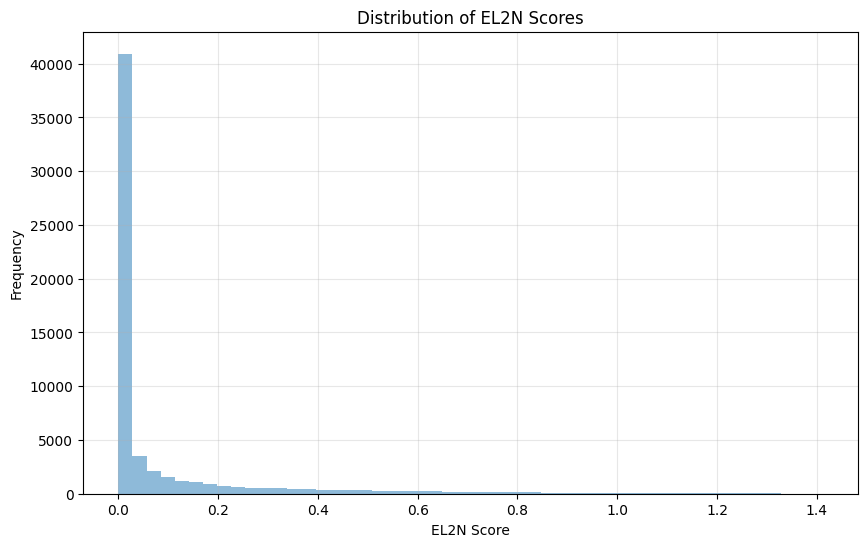

Indices with highest EL2N scores: [np.int64(51735), np.int64(42018), np.int64(23053), np.int64(46926), np.int64(44798), np.int64(44342), np.int64(16528), np.int64(40753), np.int64(33529), np.int64(13103), np.int64(20487), np.int64(16691), np.int64(13380), np.int64(44903), np.int64(38722), np.int64(34456), np.int64(29154), np.int64(49188), np.int64(1087), np.int64(36049)]
Indices with lowest EL2N scores: [np.int64(50817), np.int64(37811), np.int64(32797), np.int64(13353), np.int64(57150), np.int64(42343), np.int64(11362), np.int64(16638), np.int64(12628), np.int64(49714), np.int64(41185), np.int64(24674), np.int64(31111), np.int64(21201), np.int64(15796), np.int64(24553), np.int64(8313), np.int64(36820), np.int64(58001), np.int64(49747)]
EL2N scores saved to 'el2n_scores_fashion.csv'


In [8]:
# Convert to a more convenient format
indices = list(el2n_scores.keys())
scores = list(el2n_scores.values())

# Sort examples by EL2N scores (from highest to lowest)
sorted_indices = [idx for _, idx in sorted(zip(scores, indices), reverse=True)]
sorted_scores = sorted(scores, reverse=True)

# Visualize the distribution of EL2N scores
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=50, alpha=0.5)
plt.title('Distribution of EL2N Scores')
plt.xlabel('EL2N Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Identify examples with highest and lowest EL2N scores
num_examples = 20
highest_el2n_indices = sorted_indices[:num_examples]
lowest_el2n_indices = sorted_indices[-num_examples:]

print(f"Indices with highest EL2N scores: {highest_el2n_indices}")
print(f"Indices with lowest EL2N scores: {lowest_el2n_indices}")

# Save EL2N scores to file
import pandas as pd
df = pd.DataFrame({
    'index': indices,
    'el2n_score': scores
})
df.to_csv('el2n_scores_fashion.csv', index=False)
print("EL2N scores saved to 'el2n_scores_fashion.csv'")

### 4.1 Visualize Examples with Highest and Lowest EL2N Scores

Let's visualize some examples with the highest and lowest EL2N scores to see if there are any patterns:

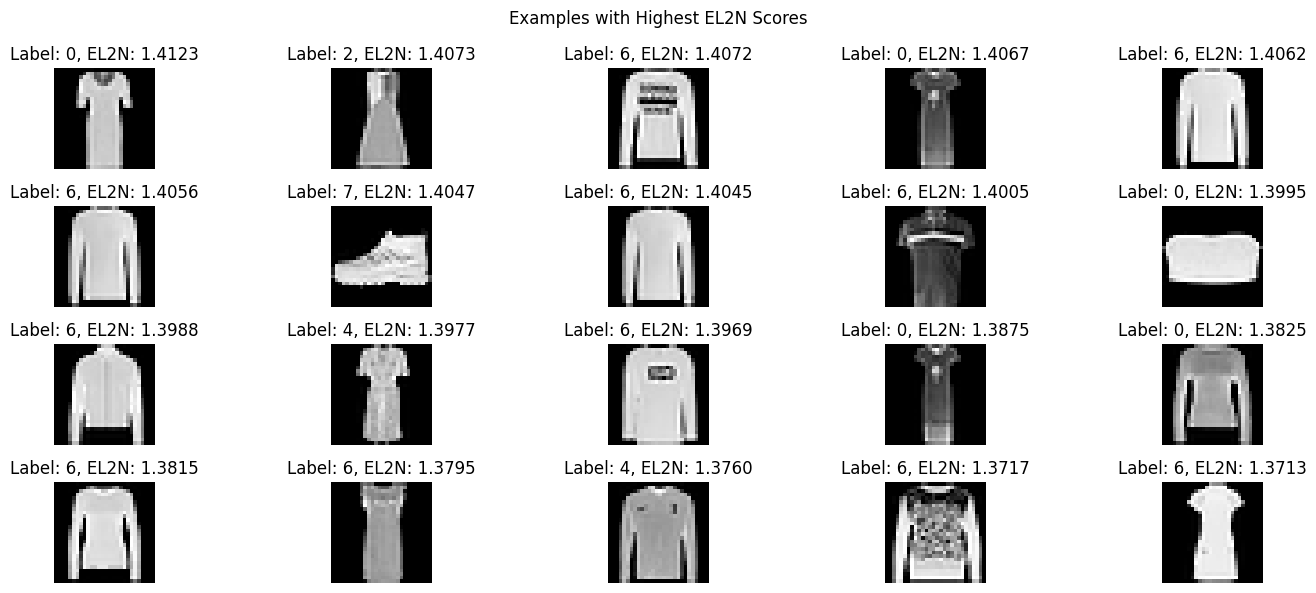

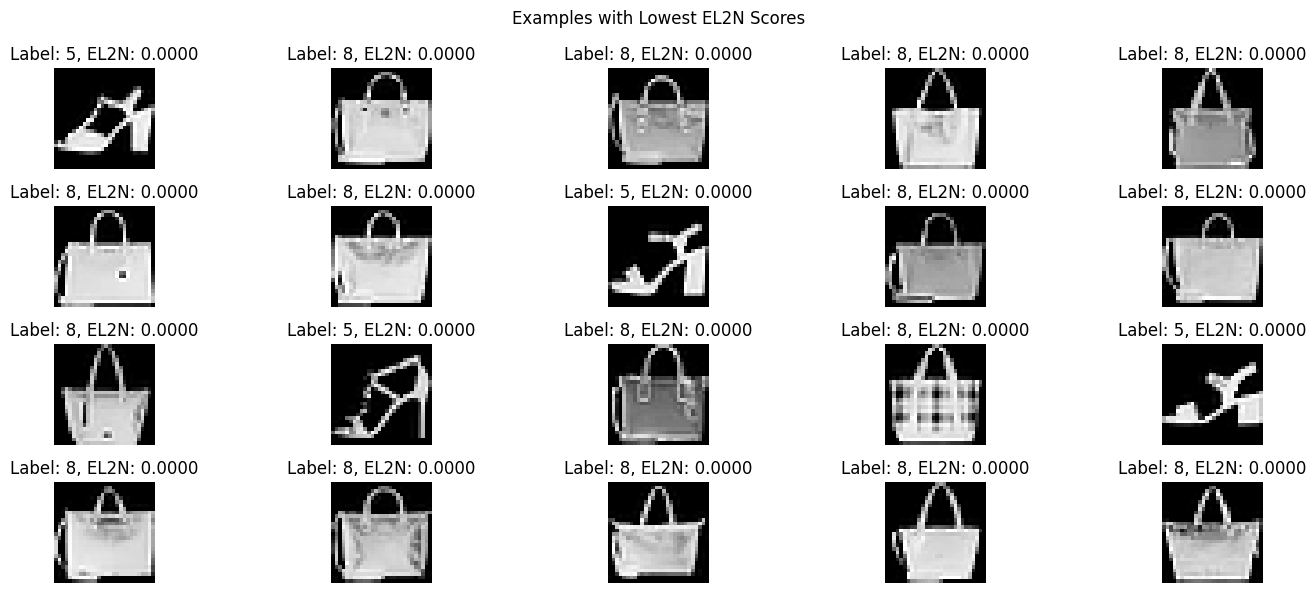

In [9]:
# Visualize some examples with highest and lowest EL2N scores
def plot_examples(dataset, indices, title):
    fig, axes = plt.subplots(4, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices[:20]):
        img, label, _ = dataset[idx]
        img = img.squeeze().numpy()
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {label}, EL2N: {el2n_scores[idx]:.4f}")
        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Plot examples with highest EL2N scores
plot_examples(mnist_train_with_indices, highest_el2n_indices, 'Examples with Highest EL2N Scores')

# Plot examples with lowest EL2N scores
plot_examples(mnist_train_with_indices, lowest_el2n_indices, 'Examples with Lowest EL2N Scores')

## 5. Evaluate Models on Original vs. Pruned Dataset

Now we'll compare the performance of models trained on the original dataset versus a pruned dataset based on EL2N scores.

In [11]:
from torch.utils.data import Subset
torch.manual_seed(42)

def evaluate_model(model, data_loader):
    """
    Evaluate model accuracy on the given data loader
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target, _ in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    return correct / total * 100

def create_pruned_dataset(dataset, el2n_scores, prune_percentage=30, remove_top_n=500):
    """
    Create a subset of the dataset by pruning examples based on EL2N scores.
    
    Args:
        dataset: The original dataset
        el2n_scores: Dictionary of {index: el2n_score}
        prune_percentage: Percentage of examples to prune (from lowest EL2N scores)
        remove_top_n: Number of examples with highest EL2N scores to remove
        
    Returns:
        Subset of the original dataset with pruned examples removed
    """
    # Convert el2n_scores to list of (idx, score) pairs
    scores_list = [(idx, score) for idx, score in el2n_scores.items()]
    
    # Sort by score (lowest first)
    sorted_scores = sorted(scores_list, key=lambda x: x[1])
    sorted_indices = [idx for idx, _ in sorted_scores]
    
    # Determine how many examples to prune from the lowest scores
    num_to_prune_low = int(len(sorted_indices) * prune_percentage / 100)
    
    # Indices to prune (those with lowest EL2N scores)
    indices_to_prune_low = set(sorted_indices[:num_to_prune_low])
    
    # Indices to prune (those with highest EL2N scores)
    if remove_top_n > 0:
        indices_to_prune_high = set(sorted_indices[-remove_top_n:])
    else:
        indices_to_prune_high = set()
        
    # Combine both sets of indices to prune
    indices_to_prune = indices_to_prune_low.union(indices_to_prune_high)
    
    # Get indices to keep
    indices_to_keep = [idx for idx in range(len(dataset)) if idx not in indices_to_prune]
    
    print(f"Original dataset size: {len(dataset)}")
    print(f"Pruned dataset size: {len(indices_to_keep)}")
    print(f"Removed {len(indices_to_prune)} examples:")
    print(f"  - {num_to_prune_low} with lowest EL2N scores")
    print(f"  - {len(indices_to_prune_high)} with highest EL2N scores")
    
    # Create a subset of the dataset with the kept indices
    pruned_dataset = Subset(dataset, indices_to_keep)
    
    return pruned_dataset

def compare_original_vs_pruned():
    """
    Compare model performance on original vs EL2N-pruned dataset
    """
    # Create pruned dataset - a direct subset of the original
    pruned_dataset = create_pruned_dataset(
        mnist_train_with_indices, 
        el2n_scores, 
        prune_percentage=30,
        remove_top_n=0
    )
    
    # Create data loaders
    original_loader = DataLoader(
        mnist_train_with_indices,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )
    
    pruned_loader = DataLoader(
        pruned_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0
    )
    
    # Train model on original dataset
    print("Training on original dataset...")
    original_model = MNISTClassifier()
    original_model = train_model(original_model, original_loader, epochs=num_epochs)
    
    # Train model on pruned dataset
    print("Training on pruned dataset...")
    pruned_model = MNISTClassifier()
    pruned_model = train_model(pruned_model, pruned_loader, epochs=num_epochs)
    
    # Evaluate on test set
    test_loader = DataLoader(
        mnist_test_with_indices,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )
    
    original_acc = evaluate_model(original_model, test_loader)
    pruned_acc = evaluate_model(pruned_model, test_loader)
    
    print(f"Test accuracy with original dataset: {original_acc:.2f}%")
    print(f"Test accuracy with pruned dataset: {pruned_acc:.2f}%")
    
    return original_acc, pruned_acc

# Run the comparison
original_acc, pruned_acc = compare_original_vs_pruned()

Original dataset size: 60000
Pruned dataset size: 42000
Removed 18000 examples:
  - 18000 with lowest EL2N scores
  - 0 with highest EL2N scores
Training on original dataset...
Epoch: 1, Batch: 100, Loss: 0.8506
Epoch: 1, Batch: 200, Loss: 0.5054
Epoch: 1, Batch: 300, Loss: 0.4241
Epoch: 1, Batch: 400, Loss: 0.3993
Epoch: 2, Batch: 100, Loss: 0.3472
Epoch: 2, Batch: 200, Loss: 0.3504
Epoch: 2, Batch: 300, Loss: 0.3205
Epoch: 2, Batch: 400, Loss: 0.3140
Epoch: 3, Batch: 100, Loss: 0.2886
Epoch: 3, Batch: 200, Loss: 0.2858
Epoch: 3, Batch: 300, Loss: 0.2884
Epoch: 3, Batch: 400, Loss: 0.2760
Epoch: 4, Batch: 100, Loss: 0.2446
Epoch: 4, Batch: 200, Loss: 0.2509
Epoch: 4, Batch: 300, Loss: 0.2561
Epoch: 4, Batch: 400, Loss: 0.2562
Epoch: 5, Batch: 100, Loss: 0.2271
Epoch: 5, Batch: 200, Loss: 0.2274
Epoch: 5, Batch: 300, Loss: 0.2306
Epoch: 5, Batch: 400, Loss: 0.2332
Epoch: 6, Batch: 100, Loss: 0.2074
Epoch: 6, Batch: 200, Loss: 0.2083
Epoch: 6, Batch: 300, Loss: 0.2059
Epoch: 6, Batch: 4

## 6. Analyze EL2N Scores by Class

Let's analyze how EL2N scores are distributed across different classes to see if certain digits are generally easier or harder to learn.

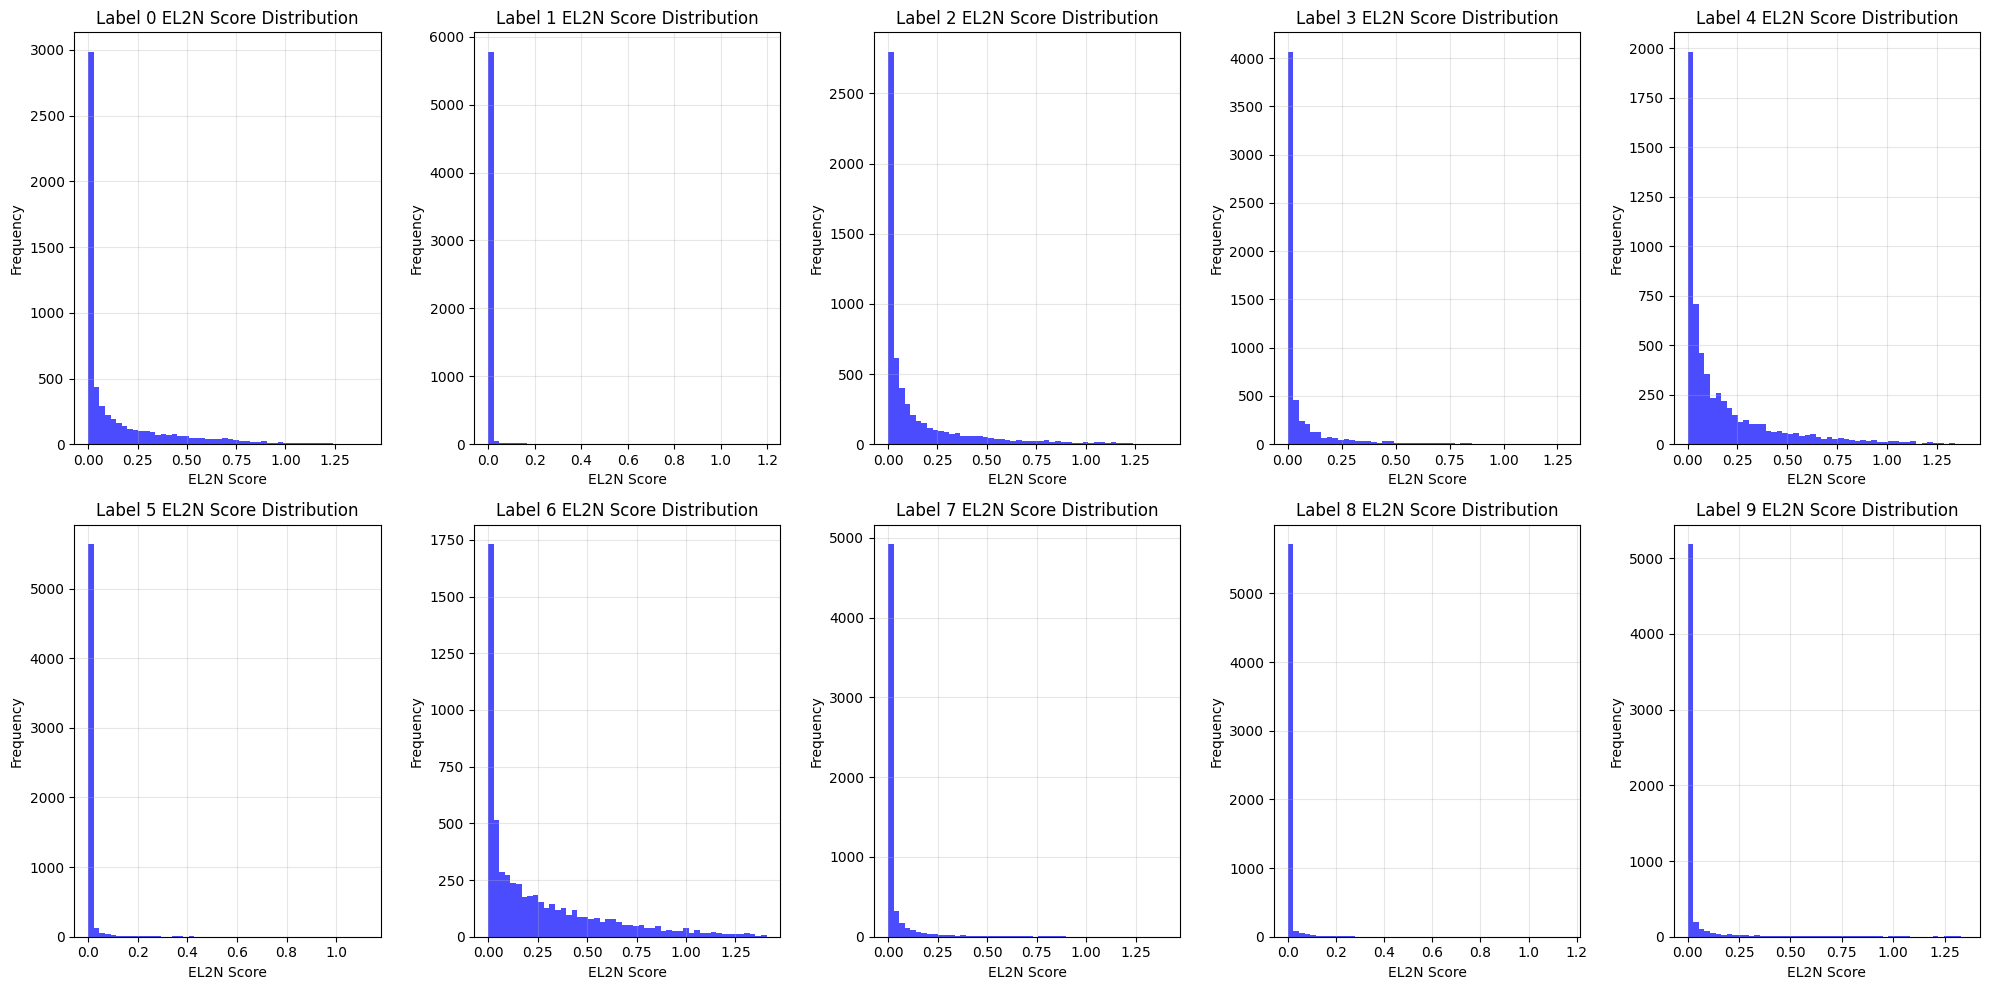

In [17]:
# Group EL2N scores by label
label_scores = {i: [] for i in range(10)}  # Assuming 10 labels (0-9)
for idx, score in el2n_scores.items():
    _, label, _ = mnist_train_with_indices[idx]
    label_scores[label].append(score)

# Plot EL2N score distribution for each label
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for label in range(10):
    axes[label].hist(label_scores[label], bins=50, alpha=0.7, color='blue')
    axes[label].set_title(f'Label {label} EL2N Score Distribution')
    axes[label].set_xlabel('EL2N Score')
    axes[label].set_ylabel('Frequency')
    axes[label].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# Analyze EL2N scores by class
el2n_scores = pd.read_csv('el2n_scores_digits.csv')
def analyze_el2n_by_class():
    """
    Analyze EL2N scores distribution by class
    """
    class_el2n = {i: [] for i in range(10)}  # For MNIST dataset with 10 classes
    
    # Group EL2N scores by class
    for idx, score in el2n_scores.items():
        _, label, _ = mnist_train_with_indices[idx]
        class_el2n[label].append(score)
    
    # Calculate statistics by class
    class_stats = {}
    for label, scores in class_el2n.items():
        class_stats[label] = {
            'mean': np.mean(scores),
            'median': np.median(scores),
            'std': np.std(scores),
            'min': np.min(scores),
            'max': np.max(scores),
            'count': len(scores)
        }
    
    # Plot mean EL2N scores by class
    plt.figure(figsize=(10, 6))
    labels = list(class_stats.keys())
    means = [class_stats[label]['mean'] for label in labels]
    
    plt.bar(labels, means)
    plt.title('Mean EL2N Score by Class')
    plt.xlabel('Class')
    plt.ylabel('Mean EL2N Score')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Return the statistics for further analysis
    return class_stats

class_stats = analyze_el2n_by_class()


IndexError: too many indices for tensor of dimension 3

## 7. Create and Save a Pruned Dataset

Finally, let's create a pruned dataset based on our EL2N scores analysis and save it for future use.

In [50]:
import pandas as pd
from torch.utils.data import Subset

# Load the EL2N scores from the CSV file
el2n_scores_df = pd.read_csv('el2n_scores.csv')

# Sort the dataframe by EL2N scores in descending order
el2n_scores_df = el2n_scores_df.sort_values(by='el2n_score', ascending=False)

# Keep only the top 50% indices
num_to_keep = len(el2n_scores_df) // 2
top_indices = el2n_scores_df.iloc[:num_to_keep]['index'].tolist()

# Discard the top 500 examples with highest scores
top_indices = top_indices[:-500]

# Create a subset of the original dataset
mnist_train_subset = Subset(mnist_train_original, top_indices)

print(f"Original dataset size: {len(mnist_train_original)}")
print(f"Subset dataset size: {len(mnist_train_subset)}")

# Save the subset dataset
mnist_train_subset_path = './data/mnist_train_subset.pt'
torch.save(mnist_train_subset, mnist_train_subset_path)

Original dataset size: 60000
Subset dataset size: 29500


In [35]:
from torch.utils.data import Subset
import os

# Create a directory to save the subsets
#subset_dir = './data/informative_subsets'
#os.makedirs(subset_dir, exist_ok=True)

# Total number of datapoints
total_datapoints = len(el2n_scores_df)

# Exclude the least informative datapoints in increments of 10%
for n in range(1, 10):  # Exclude 10%, 20%, ..., 90%
    exclude_count = n * total_datapoints // 10
    keep_count = total_datapoints - exclude_count
    
    # Get the indices to keep
    informative_indices = el2n_scores_df.iloc[:keep_count]['index'].tolist()
    
    # Create the subset
    informative_subset = Subset(mnist_train_original, informative_indices)
    
    print(informative_subset.indices[:100])
    
    
    # Save the subset
    #subset_path = os.path.join(subset_dir, f'mnist_train_informative_{100 - n * 10}p.pt')
    #torch.save(informative_subset, subset_path)
    #print(f"Saved subset excluding lowest {n * 10}% datapoints to {subset_path}")

[21177, 13446, 3606, 25097, 52631, 47937, 25213, 26327, 58347, 55989, 38451, 2943, 16725, 6030, 9761, 24273, 58417, 25275, 56019, 36578, 29115, 51873, 25205, 42775, 38671, 35928, 53925, 58257, 7928, 58293, 58174, 2983, 21328, 40299, 59707, 3009, 53335, 23967, 23871, 54859, 32556, 42361, 41231, 58956, 8991, 19201, 15816, 58269, 43172, 9821, 28343, 24271, 56247, 9586, 3911, 38441, 32418, 47871, 20526, 57482, 11314, 34249, 51101, 46995, 58474, 18544, 44685, 58204, 15229, 59067, 50935, 52015, 21238, 30070, 34947, 12619, 22698, 2941, 19727, 38049, 15525, 18905, 37731, 25422, 47921, 24204, 21490, 58200, 40394, 4102, 57493, 41861, 21788, 9321, 34779, 57499, 48013, 56406, 12821, 57559]
[21177, 13446, 3606, 25097, 52631, 47937, 25213, 26327, 58347, 55989, 38451, 2943, 16725, 6030, 9761, 24273, 58417, 25275, 56019, 36578, 29115, 51873, 25205, 42775, 38671, 35928, 53925, 58257, 7928, 58293, 58174, 2983, 21328, 40299, 59707, 3009, 53335, 23967, 23871, 54859, 32556, 42361, 41231, 58956, 8991, 19201

In [7]:
from torch.utils.data import Subset
import os
import pandas as pd

# Create a directory to save the subsets
difficulty_subset_dir = './data/difficulty_subsets'
os.makedirs(difficulty_subset_dir, exist_ok=True)

#load el2n scores from the CSV file
el2n_scores_df = pd.read_csv('el2n_scores.csv')

# Sort the EL2N scores in ascending order (easiest to hardest)
el2n_scores_df = el2n_scores_df.sort_values(by='el2n_score', ascending=True)

# Split the data into 10 difficulty levels
difficulty_splits = np.array_split(el2n_scores_df, 10)

# Create subsets for 10%, 20%, ..., 90% of the data
for subset_percentage in range(10, 100, 10):
    subset_indices = []
    for i, split in enumerate(difficulty_splits):
        # Take the corresponding percentage from each difficulty level
        num_to_take = len(split) * subset_percentage // 100
        print(f"Taking {num_to_take} examples from difficulty level {i+1} ({subset_percentage}%)")
        subset_indices.extend(split.iloc[:num_to_take]['index'].tolist())
    
    # Create the subset
    difficulty_subset = Subset(mnist_train_original, subset_indices)
    
    # Save the subset
    subset_path = os.path.join(difficulty_subset_dir, f'mnist_train_difficulty_{subset_percentage}p.pt')
    torch.save(difficulty_subset, subset_path)
    print(f"Saved {subset_percentage}% difficulty-based subset to {subset_path}")

c:\Users\Christian\uni\GANs-Data-Diet\.venv\lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Taking 600 examples from difficulty level 1 (10%)
Taking 600 examples from difficulty level 2 (10%)
Taking 600 examples from difficulty level 3 (10%)
Taking 600 examples from difficulty level 4 (10%)
Taking 600 examples from difficulty level 5 (10%)
Taking 600 examples from difficulty level 6 (10%)
Taking 600 examples from difficulty level 7 (10%)
Taking 600 examples from difficulty level 8 (10%)
Taking 600 examples from difficulty level 9 (10%)
Taking 600 examples from difficulty level 10 (10%)
Saved 10% difficulty-based subset to ./data/difficulty_subsets\mnist_train_difficulty_10p.pt
Taking 1200 examples from difficulty level 1 (20%)
Taking 1200 examples from difficulty level 2 (20%)
Taking 1200 examples from difficulty level 3 (20%)
Taking 1200 examples from difficulty level 4 (20%)
Taking 1200 examples from difficulty level 5 (20%)
Taking 1200 examples from difficulty level 6 (20%)
Taking 1200 examples from difficulty level 7 (20%)
Taking 1200 examples from difficulty level 8 (20%

In [8]:
from torch.utils.data import Subset
import os
import pandas as pd
from torchvision import transforms
from torchvision.datasets import FashionMNIST
import torch
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train_original = FashionMNIST(
    root='./data',  # Download location
    train=True,
    download=True,
    transform=transform
)

# Create a directory to save the easiest subsets
easiest_subset_dir = './data/hardest_subsets_fashion'
os.makedirs(easiest_subset_dir, exist_ok=True)

el2n_scores_df = pd.read_csv('data/el2n_scores_fashion_sorted.csv')

# Sort the EL2N scores in ascending order (easiest to hardest)
el2n_scores_df = el2n_scores_df.sort_values(by='el2n_score', ascending=False)
print(el2n_scores_df.head())
# save the sorted dataframe to a CSV file
#el2n_scores_df.to_csv('el2n_scores_sorted.csv', index=False)

# Create subsets for 10%, 20%, ..., 90% of the easiest data
total_datapoints = len(el2n_scores_df)
for subset_percentage in range(50, 100, 10):
    # Calculate the number of examples to take
    num_to_take = total_datapoints * subset_percentage // 100
    
    # Get the indices of the easiest examples
    subset_indices = el2n_scores_df.iloc[:num_to_take]['index'].tolist()
    
    # Create the subset
    easiest_subset = Subset(mnist_train_original, subset_indices)
    print(f"Subset size: {len(easiest_subset)}")
    
    #print el2n score for first 100 examples in the subset to check if they are indeed the easiest
    print(easiest_subset.indices[:100])
    
    # Save the subset
    subset_path = os.path.join(easiest_subset_dir, f'fashion_train_hardest_{subset_percentage}p.pt')
    torch.save(easiest_subset, subset_path)
    print(f"Saved {subset_percentage}% hardest subset to {subset_path}")

       index  el2n_score
59999  51735    1.412319
59998  42018    1.407318
59997  23053    1.407238
59996  46926    1.406687
59995  44798    1.406235
Subset size: 30000
[51735, 42018, 23053, 46926, 44798, 44342, 16528, 40753, 33529, 13103, 20487, 16691, 13380, 44903, 38722, 34456, 29154, 49188, 1087, 36049, 30311, 14945, 20544, 37894, 40513, 42013, 28284, 31264, 32490, 22264, 56584, 58618, 2843, 52235, 13138, 37286, 40371, 11885, 32066, 40099, 29599, 52358, 2468, 14992, 2787, 31778, 45592, 39207, 54839, 44355, 8015, 54980, 55534, 55802, 40852, 42082, 29842, 18184, 32305, 42365, 37252, 31702, 54534, 19086, 52988, 18619, 35997, 22593, 40342, 24407, 34381, 50013, 25338, 4027, 21015, 46125, 20248, 9853, 45548, 28341, 36061, 34598, 47702, 26226, 51416, 45130, 42095, 48942, 9448, 46838, 43703, 30358, 42691, 41525, 33503, 38208, 1642, 5427, 27350, 2012]
Saved 50% hardest subset to ./data/hardest_subsets_fashion\fashion_train_hardest_50p.pt
Subset size: 36000
[51735, 42018, 23053, 46926, 44798

In [10]:
from torch.utils.data import Subset
import os
import pandas as pd

# Create a directory to save the subsets
easiest_class_subset_dir = './data/easiest_class_subsets_fashion'
os.makedirs(easiest_class_subset_dir, exist_ok=True)

# Add class labels to the dataframe
class_labels = []
for idx in el2n_scores_df['index']:
    _, label = mnist_train_original[idx]
    class_labels.append(label)
el2n_scores_df['class'] = class_labels

# Group the EL2N scores by class
class_groups = el2n_scores_df.groupby('class', group_keys=True)

# Create subsets for 10%, 20%, ..., 90% of the easiest data from each class
for subset_percentage in range(50, 100, 10):
    subset_indices = []
    print(f"Processing {subset_percentage}% easiest examples from each class...")

    for digit_class, group in class_groups:
        # Calculate the number of examples to take for this class
        num_to_take = len(group) * subset_percentage // 100
        print(f"Class {digit_class}: Taking {num_to_take} examples out of {len(group)}")

        # Take the easiest examples for this class
        class_indices = group.iloc[:num_to_take]['index'].tolist()
        subset_indices.extend(class_indices)

        # Print a few indices to verify
        print(f"Class {digit_class} indices (first 5): {class_indices[:5]}")

    # Create the subset
    easiest_class_subset = Subset(mnist_train_original, subset_indices)
    print(f"Total subset size for {subset_percentage}%: {len(easiest_class_subset)}")

    # Save the subset
    subset_path = os.path.join(easiest_class_subset_dir, f'fashion_train_easiest_class_{subset_percentage}p.pt')
    torch.save(easiest_class_subset, subset_path)
    print(f"Saved {subset_percentage}% easiest class-based subset to {subset_path}")
    print("-" * 50)

Processing 50% easiest examples from each class...
Class 0: Taking 3000 examples out of 6000
Class 0 indices (first 5): [51735, 46926, 13103, 44903, 38722]
Class 1: Taking 3000 examples out of 6000
Class 1 indices (first 5): [5512, 45364, 38742, 57033, 47595]
Class 2: Taking 3000 examples out of 6000
Class 2 indices (first 5): [42018, 30311, 37894, 40513, 52235]
Class 3: Taking 3000 examples out of 6000
Class 3 indices (first 5): [36061, 42110, 55758, 51356, 39965]
Class 4: Taking 3000 examples out of 6000
Class 4 indices (first 5): [16691, 49188, 40099, 52358, 2787]
Class 5: Taking 3000 examples out of 6000
Class 5 indices (first 5): [22595, 39872, 54083, 55258, 51747]
Class 6: Taking 3000 examples out of 6000
Class 6 indices (first 5): [23053, 44798, 44342, 40753, 33529]
Class 7: Taking 3000 examples out of 6000
Class 7 indices (first 5): [16528, 42365, 34669, 39620, 9404]
Class 8: Taking 3000 examples out of 6000
Class 8 indices (first 5): [36089, 53875, 22074, 12741, 287]
Class 9: 

## 8. Analyze Class Distribution in the Pruned Dataset

Let's examine the class distribution in our pruned dataset to ensure it remains balanced.

In [51]:
# Count how many instances of each class are in the subset dataset
class_counts = {i: 0 for i in range(10)}
for _, label in mnist_train_subset:
    class_counts[label] += 1
print("Class counts in the subset dataset:")
print(class_counts)

Class counts in the subset dataset:
{0: 2528, 1: 3814, 2: 3323, 3: 2424, 4: 2356, 5: 2502, 6: 2720, 7: 3315, 8: 2652, 9: 3866}
